# Likelihood Analysis of a bright point source with fermipy

In this tutorial, we will demonstrate how to perform a standard point-source analysis of Fermi-LAT data using fermipy. 

This sample analysis is based on the PG 1553+113 analysis performed by the LAT team and described in [Abdo, A. A. et al. 2010, ApJ, 708, 1310](http://adsabs.harvard.edu/abs/2010ApJ...708.1310A) and closely follows the [Likelihood Analysis with Python](http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/python_tutorial.html) thread.  This tutorial assumes you have the most recent ScienceTools installed and [fermipy](http://fermipy.readthedocs.org) installed on top of it.  For instructions on installing fermipy and the Fermi ScienceTools you should consult the [fermipy Installation Instructions](http://fermipy.readthedocs.org/en/latest/install.html).  We will also make significant use of python, so you might want to familiarize yourself with python including matplotlib and other libraries (there's a beginner's guide at http://wiki.python.org/moin/BeginnersGuide). 

## Get the Data

For this thread the original data were extracted from the [LAT data server](http://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi) with the following selections (these selections are similar to those in the paper):

* Search Center (RA,Dec) = (238.929,11.1901)
* Radius = 30 degrees
* Start Time (MET) = 239557417 seconds (2008-08-04T15:43:37)
* Stop Time (MET) = 256970880 seconds (2009-02-22T04:48:00)
* Minimum Energy = 100 MeV
* Maximum Energy = 300000 MeV

Once you exectute the query you can download the data and put it in your working directory.  You'll need to change the names of the files to match the filenames that the data server gave you.  Alternatively you can run with the following tarball which already contains the downloaded files as well as all of the ancillary files that will be generated for the analysis.  In this example the output of the analysis will go into a subdirectory called *pg1553*.

In [2]:
import os
if os.path.isfile('../data/pg1553.tar.gz'):
    !tar xzf ../data/pg1553.tar.gz
else:
    !curl -OL https://raw.githubusercontent.com/fermiPy/fermipy-extras/master/data/pg1553.tar.gz
    !tar xzf pg1553.tar.gz

If you would like to download the raw data files used in this analysis (FT1 and FT2) you can do so by executing the following cell.

In [3]:
if os.path.isdir('../data'):
    os.environ['DATADIR'] = '../data'
else:
    !mkdir pg1553/data
    !mkdir pg1553/data/ft1
    !mkdir pg1553/data/ft2
    os.environ['DATADIR'] = 'pg1553/data'
    !curl -o pg1553/data/ft1/L1504241622054B65347F25_PH00.fits -OL https://raw.githubusercontent.com/fermiPy/fermipy-extras/master/data/ft1/L1504241622054B65347F25_PH00.fits
    !curl -o pg1553/data/ft1/L1504241622054B65347F25_PH01.fits -OL https://raw.githubusercontent.com/fermiPy/fermipy-extras/master/data/ft1/L1504241622054B65347F25_PH01.fits

    
#!curl -o pg1553/L1504241622054B65347F25_PH00.fits http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/pyLikelihood/L1504241622054B65347F25_PH00.fits
#!curl -o pg1553/L1504241622054B65347F25_PH01.fits http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/pyLikelihood/L1504241622054B65347F25_PH01.fits
#!curl -o pg1553/L1504241622054B65347F25_SC00.fits http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/pyLikelihood/L1504241622054B65347F25_SC00.fits

### Make a file list

You'll then need to make a file list with the names of your input event files. You can either just make one with a text editor or do the following from the command line.

In [4]:
!ls -1 $DATADIR/ft1/*PH*.fits > pg1553/ft1.txt

In [5]:
!cat pg1553/ft1.txt

../data/ft1/L1504241622054B65347F25_PH00.fits
../data/ft1/L1504241622054B65347F25_PH01.fits


## Make a config file

fermipy bases its analysis on a configuration file (in [yaml](http://yaml.org) format).  We're just going to use a really simple config file for a standard analysis.  There are many many more options which you can use or you can modify these options after the fact within the analysis chain.


Make a config file named 'config.yaml' like the following.  For more details on the config file see [config.html](http://fermipy.readthedocs.org/en/latest/config.html).  You will probably need to customize this a bit since your files might not be in the same place or named the same.  The galactic and isotropic diffuse will need to be located on your system (they are included in the science tools or can be downloaded from the FSSC).  In the following example we set the path to these files with the environment variable FERMI_DIFFUSE_DIR.  If FERMI_DIFFUSE_DIR is not defined fermipy will look for the location of these files within the FSSC STs distribution. 

```
data:
  evfile : ft1.txt   
  scfile : ft2.tx    

binning:
  roiwidth   : 10.0 
  binsz      : 0.1
  binsperdec : 8

selection :
  emin : 100
  emax : 300000
  tmin: 239557417 
  tmax: 256970880
  zmax    : 90
  evclass : 128
  evtype  : 3
  target : '4FGL J1555.7+1111'

gtlike:
  edisp : True
  irfs : 'P8R3_SOURCE_V3'
  edisp_disable : ['isodiff','galdiff']

model:
  src_roiwidth : 15.0
  galdiff  : '$FERMI_DIFFUSE_DIR/gll_iem_v07.fits'
  isodiff  : '$FERMI_DIFFUSE_DIR/iso_P8R3_SOURCE_V3_v1.txt'
  catalogs :
    - '4FGL'
```

## Start the analysis

Next, you create an analysis script and run the setup steps which include running the selections and generating exposure maps etc.  This will take a bit.

This is where the magic happens.  fermipy will load the point source model, create an xml file for you which contains the models for all your sources in the region of interest (ROI), decide on all the appropriate cuts and binnings and just go.  All of this is configurable from python or from the config file.  And, if you need to rerun things, it's smart enough to not overwrite files if it doesn't need to.

### Load up some useful modules

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

### Import the GTAnalysis module from fermipy

You start by importing the module and then creating an instance of the analysis object from our config file.  When instantiating the analysis object we can override any options defined in the configuration file by passing keyword arguments to the object constructor.  Here we explicitly set the verbosity parameter to 3 (INFO) which supresses DEBUG output.  When we create the object, it spits out a bunch of information about all of the parameters that were used.  You can see there are many more options than the ones we chose.

In [7]:
from fermipy.gtanalysis import GTAnalysis
gta = GTAnalysis('pg1553/config.yaml',logging={'verbosity': 3})
matplotlib.interactive(True)

2021-06-21 13:52:21 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version v1.0.1 
ScienceTools version 2.0.18


Let's take a look at the initial input event files

In [16]:
with open("pg1553/ft1.txt") as f:
    input_files = f.readlines()

input_files = [f.strip("\n") for f in input_files]
print(input_files)

['../data/ft1/L1504241622054B65347F25_PH00.fits', '../data/ft1/L1504241622054B65347F25_PH01.fits']


Read one file in as a table

In [17]:
from astropy.table import Table

In [19]:
t = Table.read(input_files[0], hdu=1)

In [20]:
t

ENERGY,RA,DEC,L,B,THETA,PHI,ZENITH_ANGLE,EARTH_AZIMUTH_ANGLE,TIME,EVENT_ID,RUN_ID,RECON_VERSION,CALIB_VERSION [3],EVENT_CLASS [32],EVENT_TYPE [32],CONVERSION_TYPE,LIVETIME,DIFRSP0,DIFRSP1,DIFRSP2,DIFRSP3,DIFRSP4
MeV,deg,deg,deg,deg,deg,deg,deg,deg,s,,,,,,,,s,,,,,
float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int32,int32,int16,int16,bool,bool,int16,float64,float32,float32,float32,float32,float32
538.79675,258.76797,11.601158,32.717495,26.587275,21.099522,69.525536,39.699387,302.11157,239646594.1632708,3154345,239645594,0,0 .. 0,False .. True,False .. True,0,130.803790807724,0.0,0.0,0.0,0.0,0.0
765.5338,258.56604,11.574936,32.59832,26.756044,57.46366,200.40448,70.16773,66.16222,239840161.56974736,8362449,239835659,0,0 .. 0,False .. True,False .. True,0,76.85447326302528,0.0,0.0,0.0,0.0,0.0
391.90915,258.77057,11.551644,32.668377,26.564293,66.689735,252.94148,38.697117,33.092915,239898124.18749014,2213352,239897571,0,0 .. 0,False .. True,False .. False,1,56.99404388666153,0.0,0.0,0.0,0.0,0.0
120.571365,258.83325,11.796055,32.94541,26.610472,44.83362,96.635826,54.28294,276.6544,239951043.89974436,1003061,239950625,0,0 .. 0,False .. True,False .. False,1,123.81579771637917,0.0,0.0,0.0,0.0,0.0
500.81796,258.63654,11.483924,32.538124,26.655235,48.03507,98.21642,57.537155,275.82956,239951099.17692286,1148299,239950625,0,0 .. 0,False .. True,False .. True,0,179.09297621250153,0.0,0.0,0.0,0.0,0.0
393.2541,259.0739,11.939454,33.20065,26.455925,32.59749,194.16124,39.280994,38.334652,240030010.17818636,10147729,240025172,0,0 .. 0,False .. True,False .. True,0,24.26987051963806,0.0,0.0,0.0,0.0,0.0
260.86182,258.9468,12.058491,33.264046,26.618439,61.366016,281.5017,31.956478,287.96527,240036675.37049332,336220,240036563,0,0 .. 0,False .. True,False .. True,0,109.3906192779541,0.0,0.0,0.0,0.0,0.0
155.16846,258.91968,11.72253,32.91009,26.502935,55.22312,197.95798,61.02289,60.150562,240138580.18634808,13479863,240133960,0,0 .. 0,False .. True,False .. True,0,78.8684054017067,0.0,0.0,0.0,0.0,0.0


### The setup routine

This gets everything ready for the likelihood analysis.  Note that fermipy will skip generating any ancillary files that already exist in the working directory.  In the sample tarball these files have already been produced in order to speed up this stage of the analysis.  If you want to see the behavior of fermipy when running from an empty working directory you can delete one or more of these files before running *setup*.

In [7]:
gta.setup()

2021-06-18 15:57:31 INFO    GTAnalysis.setup(): Running setup.
2021-06-18 15:57:31 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2021-06-18 15:57:31 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2021-06-18 15:57:31 INFO    GTBinnedAnalysis._create_ltcube(): Skipping LT Cube.
/Users/manuelmeyer/anaconda3/envs/fermipy-1.0.1-test/lib/python3.7/site-packages/fermipy/irfs.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  log_ratio = np.log(x[xs1] / x[xs0])
/Users/manuelmeyer/anaconda3/envs/fermipy-1.0.1-test/lib/python3.7/site-packages/fermipy/irfs.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as

Before proceeding with the analysis we'll have a quick look at the files that are produced by the setup function.

In [8]:
ls pg1553/*fits

pg1553/bexpmap_00.fits      pg1553/fit0.fits
pg1553/bexpmap_roi_00.fits  pg1553/ft1_00.fits
pg1553/ccube.fits           pg1553/ltcube_00.fits
pg1553/ccube_00.fits        pg1553/srcmap_00.fits


Here is a brief explanation of the contents of each file and its role in the analysis:

* **ft1_00.fits**: Event list.  This is generated by running gtselect and gtmktime on our input file list.
* **bexpmap_00.fits**: All-sky binned exposure map.  This map is interpolated to create an exposure model when generating the srcmap file.
* **bexpmap_roi_00.fits**: Binned exposure map for the ROI.  This file is only provided for visualization purposes in order to have an exposure map with the same binning as the data and model maps.
* **ccube_00.fits**: Counts cube for the ROI.
* **ltcube_00.fits**: Livetime cube.  This contains a map of the livetime for this observation over the whole sky as a function of incidence angle.
* **srcmap_00.fits**: Source map cube.  This file contains maps for each of the components in the ROI after convolution with exposure and the PSF.  Note that energy dispersion is applied at run-time.

Note that all of the files have a numerical suffix '00'.  This is the analysis component index.  In a multi-component analysis there would be instances of all of the above files for each analysis component.  The files with no component index are co-added maps that are provided for visualization purposes.

To see example of one of these files we can open and plot the counts cube file.  This is a 3D cube that contains the distribution of events as a function of energy and two spatial coordinates.  In the example below we sum over the energy dimension of the cube to make a 2-D sky image.

Filename: pg1553/ccube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (100, 100, 28)   float32   
  1  EBOUNDS       1 BinTableHDU     22   28R x 4C   [I, E, E, E]   


/Users/manuelmeyer/anaconda3/envs/fermipy-1.0.1-test/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/manuelmeyer/anaconda3/envs/fermipy-1.0.1-test/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/manuelmeyer/anaconda3/envs/fermipy-1.0.1-test/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: Matplotl

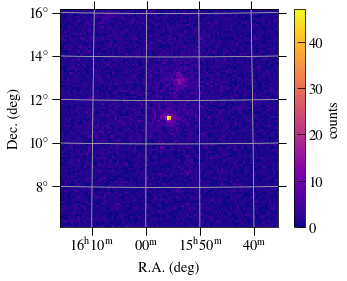

In [9]:
from astropy.io import fits
from astropy.wcs import WCS

h = fits.open('pg1553/ccube.fits')
h.info()

wcs = WCS(h[0].header).dropaxis(-1)  # load the coordinate system, drop the energy axis

counts = h[0].data

plt.subplot(projection=wcs)
im = plt.imshow(np.sum(counts,axis=0),interpolation='nearest',origin='lower', cmap='plasma')
plt.colorbar(im, label="counts")

plt.grid()
plt.gca().tick_params(direction='out')
plt.gca().set_xlabel("R.A. (deg)")
plt.gca().set_ylabel("Dec. (deg)")

Next, we look at the sky map of the exposure

Filename: pg1553/bexpmap_roi_00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   (100, 100, 29)   float32   
  1  ENERGIES      1 BinTableHDU     13   29R x 1C   [1D]   
  2  GTI           1 BinTableHDU     18   3066R x 2C   [D, D]   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/manuelmeyer/anaconda3/envs/fermipy-1.0.1-test/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/manuelmeyer/anaconda3/envs/fermipy-1.0.1-test/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/manuelmeyer/anaconda3/envs/fermipy-1.0.1-test/lib/python3

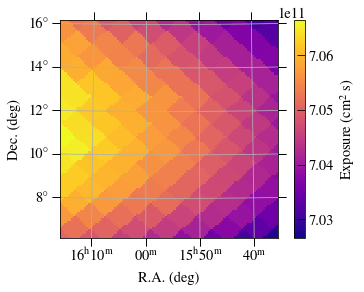

In [10]:
exp = fits.open('pg1553/bexpmap_roi_00.fits')
exp.info()
exposure = exp[0].data

wcs = WCS(exp[0].header).dropaxis(-1)  # load the coordinate system, drop the energy axis

plt.subplot(projection=wcs)
im = plt.imshow(np.sum(exposure,axis=0),interpolation='nearest',origin='lower', cmap='plasma')
plt.colorbar(im, label="Exposure (cm$^{2}$ s)")

plt.grid()
plt.gca().tick_params(direction='out')
plt.gca().set_xlabel("R.A. (deg)")
plt.gca().set_ylabel("Dec. (deg)")

... and the energy dependence of the exposure for the central pixel

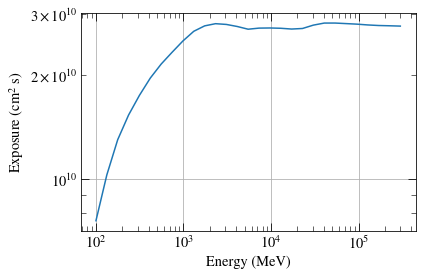

In [11]:
energy = exp[1].data
plt.loglog(energy, exposure[:, 50, 50])
plt.ylabel("Exposure (cm$^{2}$ s)")
plt.xlabel("Energy (MeV)")
plt.grid()

Let's look at the predicted number of counts from the model

We can now inspect the state of the ROI prior with the print_roi() method.

In [12]:
gta.print_roi()

2021-06-18 15:57:50 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1555.7+1111   PointSource    LogParabola       0.000       nan       847.6
4FGL J1553.6+1257   PointSource    LogParabola       1.838       nan       372.1
4FGL J1603.8+1104   PointSource    PowerLaw          1.994       nan        48.3
4FGL J1552.0+0850   PointSource    PowerLaw          2.516       nan        49.0
4FGL J1608.7+1029   PointSource    LogParabola       3.262       nan       324.8
4FGL J1606.6+1324   PointSource    PowerLaw          3.473       nan        56.4
4FGL J1546.0+0819   PointSource    PowerLaw          3.726       nan        67.8
4FGL J1548.3+1456   PointSource    LogParabola       4.160       nan       158.7
4FGL J1539.1+1008   PointSource    PowerLaw          4.201       nan        48.4
4FGL J1541.7+1413   PointSource    PowerLaw          4.5

Additional details about an individual source can be retrieved by printing the corresponding source object.  Here we use the bracket operator to return the properties of PG1553. 

In [13]:
print(gta.roi['4FGL J1555.7+1111'])

Name           : 4FGL J1555.7+1111
Associations   : ['4FGL J1555.7+1111', 'PG 1553+113']
RA/DEC         :    238.931/    11.188
GLON/GLAT      :     21.908/    43.962
TS             : nan
Npred          : 847.56
Flux           : 4.546e-08 +/-      nan
EnergyFlux     : 0.0001302 +/-      nan
SpatialModel   : PointSource
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :  3.602e-12 +/-        nan
b'alpha'       :      1.536 +/-        nan
b'beta'        :    0.07047 +/-        nan
b'Eb'          :       1847 +/-        nan


## Do the likelihood fitting

Now that all of the ancillary files have been generated, we can move on to the actual fitting.  The first thing you should do is free some of the sources since all of the sources are initially fixed.  We'll just free those sources in the center region.

In [14]:
gta.free_sources(free=False) # make sure everything is fixed first

# Free Normalization of all Sources within 3 deg of ROI center
gta.free_sources(distance=3.0, pars='norm')

# Free normalizations of isotropic and galactic diffuse components
gta.free_source('galdiff', pars='norm')
gta.free_source('isodiff')

2021-06-18 15:57:50 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1555.7+1111     : ['norm']
2021-06-18 15:57:50 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1553.6+1257     : ['norm']
2021-06-18 15:57:50 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1603.8+1104     : ['Prefactor']
2021-06-18 15:57:50 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1552.0+0850     : ['Prefactor']
2021-06-18 15:57:50 INFO    GTAnalysis.free_source(): Freeing parameters for isodiff               : ['Normalization']
2021-06-18 15:57:50 INFO    GTAnalysis.free_source(): Freeing parameters for galdiff               : ['Prefactor']


In this simple anlaysis we are leaving the spectral shapes of sources fixed but we're going to free the spectral shape of the source we care about.  

In [15]:
gta.free_source('4FGL J1555.7+1111')

2021-06-18 15:57:50 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1555.7+1111     : ['alpha', 'beta']


Now, actually do the fit.  The software does its best to get the fit to converge by running the fit several times.

In [16]:
fit_results = gta.fit()

2021-06-18 15:57:50 INFO    GTAnalysis.fit(): Starting fit.
2021-06-18 15:57:51 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2021-06-18 15:57:51 INFO    GTAnalysis.fit(): LogLike:   -50222.036 DeltaLogLike:      356.518 


The dictionary returned by the fit method returns a variety of diagnostic information about the fit including the fit quality, the relative improvement in the likelihood, and the correlations among the fit parameters.  We can inspect the results of the fit by printing the source object for PG1553.

In [17]:
print('Fit Quality: ',fit_results['fit_quality'])
print(gta.roi['4FGL J1555.7+1111'])

Fit Quality:  3
Name           : 4FGL J1555.7+1111
Associations   : ['4FGL J1555.7+1111', 'PG 1553+113']
RA/DEC         :    238.931/    11.188
GLON/GLAT      :     21.908/    43.962
TS             : 2774.01
Npred          : 1046.07
Flux           : 5.706e-08 +/- 5.87e-09
EnergyFlux     : 0.0001939 +/- 2.08e-05
SpatialModel   : PointSource
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :  4.196e-12 +/-  2.217e-13
b'alpha'       :      1.529 +/-     0.0471
b'beta'        :    0.04564 +/-    0.01806
b'Eb'          :       1847 +/-        nan


Let's have a look at the sources and the best-fit parameters after the fit

In [18]:
gta.print_roi()

2021-06-18 15:57:51 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1555.7+1111   PointSource    LogParabola       0.000   2774.01      1046.1
4FGL J1553.6+1257   PointSource    LogParabola       1.838   1099.48      1607.9
4FGL J1603.8+1104   PointSource    PowerLaw          1.994      6.46        54.4
4FGL J1552.0+0850   PointSource    PowerLaw          2.516     48.98       162.2
4FGL J1608.7+1029   PointSource    LogParabola       3.262       nan       324.8
4FGL J1606.6+1324   PointSource    PowerLaw          3.473       nan        56.4
4FGL J1546.0+0819   PointSource    PowerLaw          3.726       nan        67.8
4FGL J1548.3+1456   PointSource    LogParabola       4.160       nan       158.7
4FGL J1539.1+1008   PointSource    PowerLaw          4.201       nan        48.4
4FGL J1541.7+1413   PointSource    PowerLaw          4.5

In [19]:
gta.print_params()

2021-06-18 15:57:51 INFO    GTAnalysis.print_params(): 
 idx parname                  value     error       min       max     scale free
--------------------------------------------------------------------------------
4FGL J1552.0+0850
  42 Prefactor                 3.09     0.638     1e-05     1e+03     1e-13    *
  43 Index                     2.05         0         0         5        -1     
  44 Scale                 1.92e+03         0  1.92e+03  1.92e+03         1     
4FGL J1553.6+1257
  45 norm                      2.59     0.121     1e-05     1e+03     1e-11    *
  46 alpha                     2.28         0        -5         5         1     
  47 beta                     0.115         0        -2         2         1     
  48 Eb                         677         0       677       677         1     
4FGL J1555.7+1111
  49 norm                      0.42    0.0222     1e-05     1e+03     1e-11    *
  50 alpha                     1.53    0.0471        -5         5         1    *

You can then save the state of the roi to an output file for reference later.  The write_roi function does this.  The first argument is a string that will be prepended to the names of the output files generated by this method.

2021-06-18 15:57:51 INFO    GTBinnedAnalysis.write_xml(): Writing /Users/manuelmeyer/Python/fermipy-extra/notebooks/pg1553/fit0_00.xml...
2021-06-18 15:57:51 INFO    GTAnalysis.write_fits(): Writing /Users/manuelmeyer/Python/fermipy-extra/notebooks/pg1553/fit0.fits...
2021-06-18 15:58:01 INFO    GTAnalysis.write_roi(): Writing /Users/manuelmeyer/Python/fermipy-extra/notebooks/pg1553/fit0.npy...
/Users/manuelmeyer/anaconda3/envs/fermipy-1.0.1-test/lib/python3.7/site-packages/fermipy/plotting.py:146: MatplotlibDeprecationWarning: Passing raw data via parameters data and lut to register_cmap() is deprecated since 3.3 and will become an error two minor releases later. Instead use: register_cmap(cmap=LinearSegmentedColormap(name, data, lut))
  plt.register_cmap(name='ds9_b', data=ds9_b)
/Users/manuelmeyer/anaconda3/envs/fermipy-1.0.1-test/lib/python3.7/site-packages/fermipy/plotting.py:301: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In futur

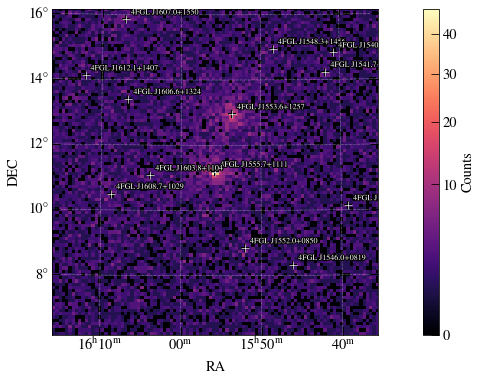

In [20]:
gta.write_roi('fit0',make_plots=True)

There are a lot of diagnostic plots also saved at the same time.  

In [21]:
ls -l pg1553/*.png

-rw-r--r--  1 manuelmeyer  staff  68147 Jun 18 15:58 pg1553/fit0_counts_map_2.000_5.477.png
-rw-r--r--  1 manuelmeyer  staff  24507 Jun 18 15:58 pg1553/fit0_counts_map_xproj_2.000_5.477.png
-rw-r--r--  1 manuelmeyer  staff  25814 Jun 18 15:58 pg1553/fit0_counts_map_yproj_2.000_5.477.png
-rw-r--r--  1 manuelmeyer  staff  59182 Jun 18 15:58 pg1553/fit0_counts_spectrum.png
-rw-r--r--  1 manuelmeyer  staff  56872 Jun 18 15:58 pg1553/fit0_model_map_2.000_5.477.png


In [22]:
from IPython.display import Image, display
from glob import glob

In [23]:
pngs = glob('pg1553/*.png')

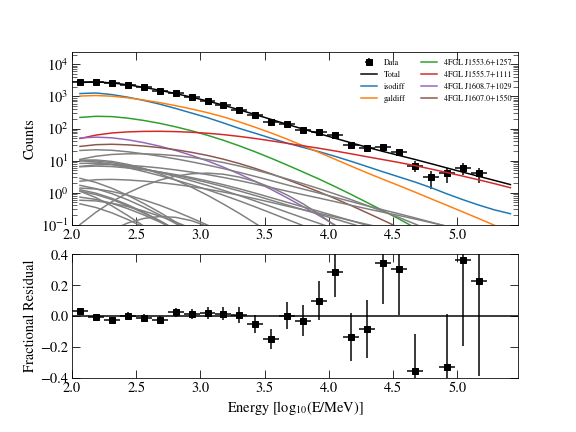

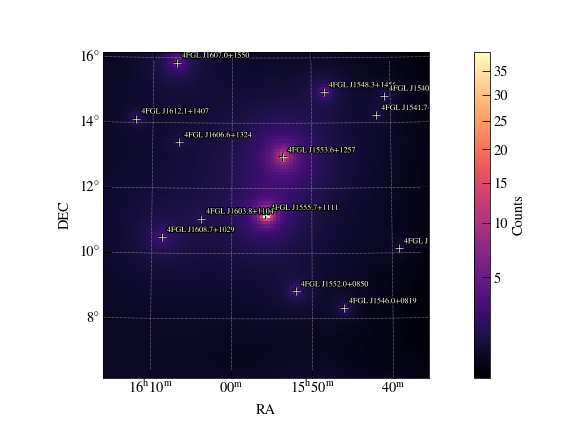

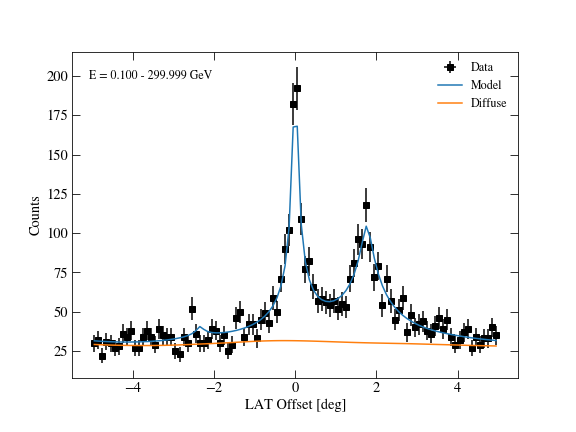

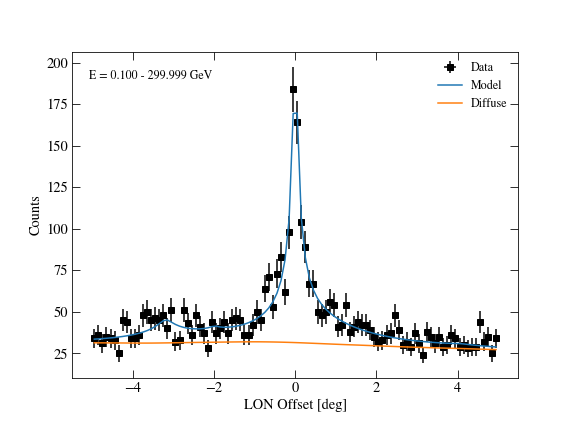

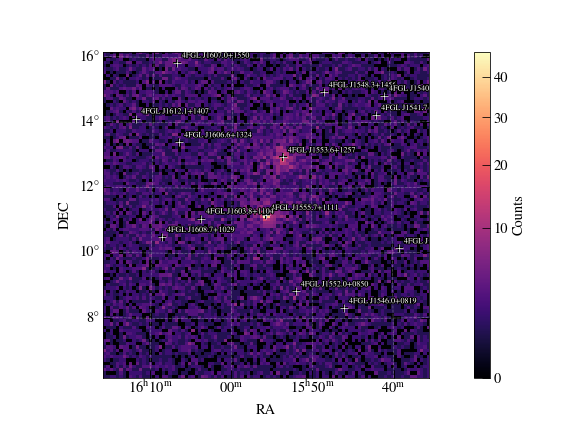

In [24]:
for png in pngs:
    my_image = Image(png)
    display(my_image)

### Reading in the results

Since the results are saved, you can load them back up at any point (you can also get to these within python).  Here we retrieve the analysis results from the output numpy file. 

In [25]:
c = np.load('pg1553/fit0.npy', allow_pickle=True).flat[0]

The `sources` dictionary has an entry for each source in the model:

In [26]:
sorted(c['sources'].keys())

['4FGL J1527.8+1013',
 '4FGL J1531.6+0406',
 '4FGL J1538.9+0425',
 '4FGL J1539.1+1008',
 '4FGL J1540.7+1449',
 '4FGL J1541.7+1413',
 '4FGL J1542.3+1801',
 '4FGL J1543.6+0452',
 '4FGL J1546.0+0819',
 '4FGL J1546.5+1816',
 '4FGL J1548.3+1456',
 '4FGL J1549.6+1710',
 '4FGL J1550.7+0528',
 '4FGL J1552.0+0850',
 '4FGL J1553.6+1257',
 '4FGL J1555.7+1111',
 '4FGL J1603.8+1104',
 '4FGL J1606.6+1324',
 '4FGL J1607.0+1550',
 '4FGL J1608.7+1029',
 '4FGL J1612.1+1407',
 '4FGL J1612.4+0409',
 '4FGL J1623.4+0858',
 '4FGL J1626.4+1820',
 'galdiff',
 'isodiff']

Let's take a look at the flux, spectral parameters, and TS.

In [27]:
c['sources']['4FGL J1555.7+1111']['flux']

5.7059566759999965e-08

In [28]:
print(c['sources']['4FGL J1555.7+1111']['param_names'][:4])
print(c['sources']['4FGL J1555.7+1111']['param_values'][:4])

[b'norm' b'alpha' b'beta' b'Eb']
[4.19564215e-12 1.52884596e+00 4.56362727e-02 1.84673450e+03]


In [29]:
c['sources']['4FGL J1555.7+1111']['ts']

2774.0086986322713

The SED is in there as well.  We can plot it.

In [30]:
E = np.array(c['sources']['4FGL J1555.7+1111']['model_flux']['energies'])
dnde = np.array(c['sources']['4FGL J1555.7+1111']['model_flux']['dnde'])
dnde_hi = np.array(c['sources']['4FGL J1555.7+1111']['model_flux']['dnde_hi'])
dnde_lo = np.array(c['sources']['4FGL J1555.7+1111']['model_flux']['dnde_lo'])

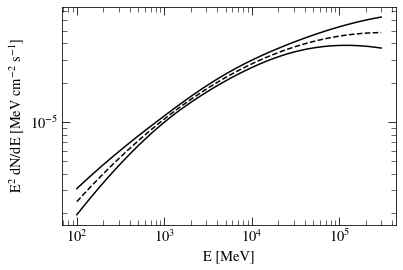

In [31]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^2$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

If you want SED points, there's a function for that.  There are lots of options for this which you can set in the config file or from keyword arguments of the function itself.

In [32]:
sed = gta.sed('4FGL J1555.7+1111')

2021-06-18 15:58:04 INFO    GTAnalysis.sed(): Computing SED for 4FGL J1555.7+1111
2021-06-18 15:58:04 INFO    GTAnalysis._make_sed(): Fitting SED
2021-06-18 15:58:04 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1555.7+1111     : ['alpha', 'beta']
2021-06-18 15:58:10 INFO    GTAnalysis.sed(): Finished SED
2021-06-18 15:58:17 INFO    GTAnalysis.sed(): Execution time: 12.52 s


You can save the state to the yaml file or you can just access it directly.  This is also the way to get at the dictionary for any individual source.

In [33]:
src = gta.roi['4FGL J1555.7+1111']

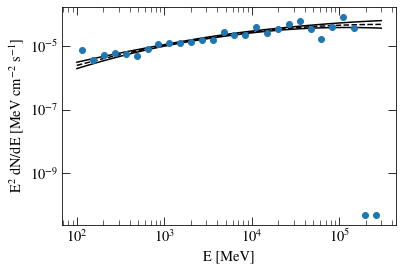

In [34]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(np.array(sed['e_ctr']),
             sed['e2dnde'], 
             yerr=sed['e2dnde_err'], fmt ='o')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

Looks like those last two points should be upper limits.  Let's plot those instead.

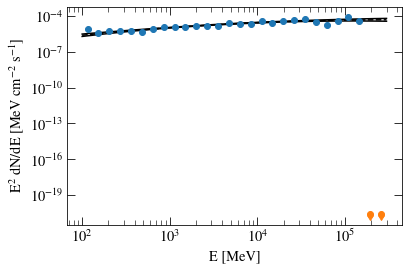

In [35]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(sed['e_ctr'][:-2],
             sed['e2dnde'][:-2], 
             yerr=sed['e2dnde_err'][:-2], fmt ='o')
plt.errorbar(np.array(sed['e_ctr'][-2:]),
         sed['e2dnde_ul95'][-2:], yerr=0.2*sed['e2dnde_ul95'][-2:], 
             fmt='o', uplims=True)
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

### Summary

There is a lot of other functionality and you should look through the docs for more details.  You can also inspect the GTAnalysis object for some of these (like TS Maps, extension tests, and using event types).  Following threads cover some of the more advanced functionality of fermipy:

* [IC443](ic443.ipynb) : Analysis to measure the angular extension of the SNR IC443.
* [Draco](draco.ipynb) : DM upper limit analysis of the Draco dwarf spheroidal galaxy.